In [1]:
# ✅ Install dependencies (if not already)
!pip install -q --upgrade scikit-learn==1.1.3 imbalanced-learn==0.10.1

# ✅ Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, accuracy_score, cohen_kappa_score,
                             precision_score, recall_score, f1_score,
                             roc_curve, auc, roc_auc_score, matthews_corrcoef)
from imblearn.metrics import geometric_mean_score, specificity_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 53.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 8.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.


2025-07-01 20:16:16.587174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751400977.163022      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751400977.304858      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ✅ Pretrained models
from tensorflow.keras.applications import (
    VGG16, VGG19, ResNet50V2, InceptionV3, InceptionResNetV2,
    DenseNet121, DenseNet169, DenseNet201, Xception, EfficientNetB0,
    MobileNetV3Large
)

In [3]:
# ✅ Dataset paths
violence_folder = '/kaggle/input/matasets/Mdataset/fights'
nonviolence_folder = '/kaggle/input/matasets/Mdataset/noFights'

In [4]:
# ✅ Load image function
def load_images_from_folder(folder, label):
    images, labels = [], []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        try:
            img = load_img(path, target_size=(224, 224))
            img = img_to_array(img) / 255.0
            images.append(img)
            labels.append(label)
        except:
            print(f"Error loading {path}")
    return np.array(images), np.array(labels)

In [5]:
# ✅ Build model
def build_transfer_learning_model(base_model_fn, input_shape=(224, 224, 3), lr=0.001):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [6]:
# ✅ Load and prepare data
v_images, v_labels = load_images_from_folder(violence_folder, 1)
nv_images, nv_labels = load_images_from_folder(nonviolence_folder, 0)
X = np.concatenate((v_images, nv_images), axis=0)
y = np.concatenate((v_labels, nv_labels), axis=0)
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✅ Dataset: {len(y)} samples")

✅ Dataset: 452 samples


In [7]:
# ✅ Models to train
models = [
    ("VGG16", VGG16),
    ("VGG19", VGG19),
    ("MobileNetV3Large", MobileNetV3Large),
    ("ResNet50V2", ResNet50V2),
    ("InceptionResNetV2", InceptionResNetV2),
    ("DenseNet121", DenseNet121),
    ("DenseNet169", DenseNet169),
    ("DenseNet201", DenseNet201),
    ("InceptionV3", InceptionV3),
    ("EfficientNetB0", EfficientNetB0),
    ("Xception", Xception)
]

In [8]:
# ✅ For storing all ROC curves
roc_data = []

# ✅ Evaluation function with ROC data collection
def evaluate(model, X_test, y_test, model_name):
    y_probs = model.predict(X_test).flatten()
    y_pred = (y_probs > 0.5).astype(int)

    print(f"\n📊 Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    # ✅ Store ROC curve data
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_data.append((model_name, fpr, tpr))

    # ✅ Metrics
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auroc = roc_auc_score(y_test, y_probs, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    spec = specificity_score(y_test, y_pred, average='weighted')
    gmean = geometric_mean_score(y_test, y_pred, average='weighted')
    type_i = 1 - gmean
    type_ii = 1 - spec

    return [model_name, acc, kappa, prec, rec, f1, auroc, mcc, spec, gmean, type_i, type_ii]

In [9]:
# ✅ Train, evaluate and collect results
results = []
for name, model_fn in models:
    print(f"\n🚀 Training {name}...")
    model = build_transfer_learning_model(model_fn)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=6, batch_size=32, verbose=1)
    results.append(evaluate(model, X_test, y_test, name))


🚀 Training VGG16...


I0000 00:00:1751401006.607406      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751401006.608319      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/6


I0000 00:00:1751401012.445081     104 service.cc:148] XLA service 0x7ac75800f0a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751401012.446972     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751401012.446992     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751401012.956007     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/12 ━━━━━━━━━━━━━━━━━━━━ 2:45 15s/step - accuracy: 0.3438 - loss: 0.7965

I0000 00:00:1751401025.017235     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.6159 - loss: 0.6379 - val_accuracy: 0.9451 - val_loss: 0.3644
Epoch 2/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.8599 - loss: 0.3666 - val_accuracy: 0.9451 - val_loss: 0.2628
Epoch 3/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.9098 - loss: 0.2576 - val_accuracy: 0.9451 - val_loss: 0.2064
Epoch 4/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9380 - loss: 0.2040 - val_accuracy: 0.9121 - val_loss: 0.2427
Epoch 5/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9203 - loss: 0.2072 - val_accuracy: 0.9121 - val_loss: 0.2240
Epoch 6/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.9699 - loss: 0.1610 - val_accuracy: 0.9341 - val_loss: 0.1646
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step

📊 Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        32
           1       0.98      0.92      0.95        59

    accurac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7788 - loss: 0.3951 - val_accuracy: 0.9341 - val_loss: 0.1342
Epoch 2/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.9571 - loss: 0.1206 - val_accuracy: 0.9451 - val_loss: 0.0796
Epoch 3/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.9736 - loss: 0.0662 - val_accuracy: 0.9451 - val_loss: 0.0986
Epoch 4/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.9847 - loss: 0.0323 - val_accuracy: 0.9670 - val_loss: 0.0850
Epoch 5/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.9976 - loss: 0.0098 - val_accuracy: 0.9560 - val_loss: 0.0668
Epoch 6/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.9780 - val_loss: 0.0775
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step  

📊 Classification Report for Xception:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
   

In [10]:
# ✅ Save all results to CSV
results_df = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "Cohen-Kappa", "Precision", "Recall", "F1-Score",
    "AUROC", "MCC", "Specificity", "G-Mean", "Type I Error", "Type II Error"])
results_df.to_csv("/kaggle/working/all_model_results.csv", index=False)
print("\n✅ Results saved to /kaggle/working/all_model_results.csv")
display(results_df)


✅ Results saved to /kaggle/working/all_model_results.csv


,Model,Accuracy,Cohen-Kappa,Precision,Recall,F1-Score,AUROC,MCC,Specificity,G-Mean,Type I Error,Type II Error
0,VGG16,0.934066,0.859423,0.939372,0.934066,0.934848,0.994174,0.863222,0.949938,0.941969,0.058031,0.050062
1,VGG19,0.934066,0.859423,0.939372,0.934066,0.934848,0.990466,0.863222,0.949938,0.941969,0.058031,0.050062
2,MobileNetV3Large,0.945055,0.876861,0.946045,0.945055,0.944385,0.984110,0.879264,0.912996,0.928887,0.071113,0.087004
3,ResNet50V2,0.978022,0.951102,0.978743,0.978022,0.977851,0.997881,0.952241,0.959478,0.968706,0.031294,0.040522
4,InceptionResNetV2,0.912088,0.807203,0.912088,0.912088,0.912088,0.971928,0.807203,0.895115,0.903562,0.096438,0.104885
5,DenseNet121,0.934066,0.855403,0.934066,0.934066,0.934066,0.991525,0.855403,0.921337,0.927679,0.072321,0.078663
6,DenseNet169,0.989011,0.975727,0.989194,0.989011,0.988970,0.998941,0.976014,0.979739,0.984364,0.015636,0.020261
7,DenseNet201,0.978022,0.951102,0.978743,0.978022,0.977851,0.989936,0.952241,0.959478,0.968706,0.031294,0.040522
8,InceptionV3,0.978022,0.952480,0.979315,0.978022,0.978166,0.999470,0.953558,0.988080,0.983038,0.016962,0.011920
9,EfficientNetB0,0.351648,0.000000,0.123657,0.351648,0.182972,0.797669,0.000000,0.648352,0.477485,0.522515,0.351648


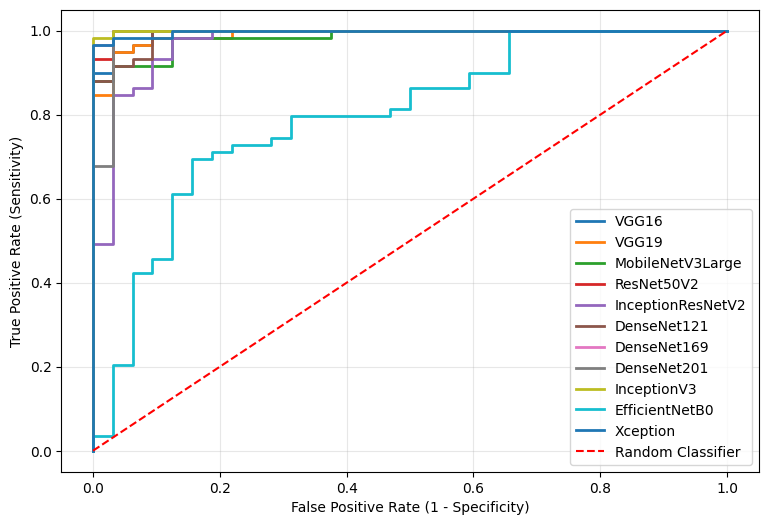

<Figure size 640x480 with 0 Axes>

In [11]:
# ✅ Plot ALL ROC curves together
plt.figure(figsize=(9,6))
for model_name, fpr, tpr in roc_data:
    plt.plot(fpr, tpr, lw=2, label=model_name)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
# ✅ Optional: Save the figure
plt.savefig("movie_multi_model_roc_curve.png", dpi=300)
plt.show()